# Sprint 2 Preprocessing and Baseline Modelling
# Attractions
---

In [1]:
# data analysis / modification 
import pandas as pd
import numpy as np
# plotting libraries
import matplotlib.pyplot as plt
# libraries for proprocessing 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
# libraries for modelling
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

from warnings import filterwarnings
filterwarnings(action='ignore')

## Table of Contents
- Processing
    - Filter and Transform Latitude and Longitude
    - Text Analysis on Review Keywords
    - Transform and Scale Reviews and Ratings
    - PCA Transformation for Final Model Data 
- Modelling
- Next Steps for Sprint 3
--- 


## Preprocessing

### Filter and Transform Latitude and Longitude  

View the original distribution of the `lat` and `lon` columns in the address dataset. With skewed data, the tail region may act as an outlier for the statistical model, affect a model's performance. To correct the skewed columns require using log transformation.

In [2]:
address_df = pd.read_csv('van_attractions_lat_lon_v2_merged.csv')
print(f'Shape of address_df: {address_df.shape} \n')
address_df.head()

Shape of address_df: (961, 23) 



,original_address,lat,lon,formatted,name,housenumber,street,postcode,suburb,district,...,state_code,country,country_code,confidence,confidence_city_level,confidence_street_level,confidence_building_level,attribution,attribution_license,attribution_url
0,"7815 Kingsway, Burnaby, BC V3N 3E4",49.214312,-122.940006,"7815 Kingsway, Burnaby, BC V3N 3C9, Canada",NaN,7815,Kingsway,V3N 3C9,NaN,Edmonds,...,BC,Canada,ca,1.000000,1.0,1.000000,1.000000,© OpenStreetMap contributors,Open Database License,https://www.openstreetmap.org/copyright
1,"7515, 200 Market Crossing #200, Burnaby, BC V5...",49.198066,-122.978829,"Barcelos, 7515 Market Crossing, Burnaby, BC V5...",Barcelos,7515,Market Crossing,V5J 0A3,Market Crossing,NaN,...,BC,Canada,ca,0.666667,1.0,0.666667,0.666667,© OpenStreetMap contributors,Open Database License,https://www.openstreetmap.org/copyright
2,"Market Crossing, Burnaby, BC V5J 3J3",49.199441,-122.979538,"Market Crossing, Burnaby, BC V5J 0A3, Canada",Market Crossing,NaN,Market Crossing,V5J 0A3,Market Crossing,NaN,...,BC,Canada,ca,1.000000,1.0,1.000000,NaN,© OpenStreetMap contributors,Open Database License,https://www.openstreetmap.org/copyright
3,"5624 Marine Dr, Burnaby, BC V5J 3G8",49.206079,-122.982034,"5624 Marine Drive, Burnaby, BC V5J 3G8, Canada",NaN,5624,Marine Drive,V5J3G8,Big Bend,NaN,...,BC,Canada,ca,1.000000,1.0,1.000000,1.000000,© OpenAddresses contributors,BSD-3-Clause License,NaN
4,"4949 Canada Wy, Burnaby, BC V5G 4A3",49.243496,-122.973016,"Burnaby Artisan Farmers' Market, 4949 Canada W...",Burnaby Artisan Farmers' Market,4949,Canada Way,V5G 4A3,NaN,NaN,...,BC,Canada,ca,1.000000,1.0,1.000000,1.000000,© OpenStreetMap contributors,Open Database License,https://www.openstreetmap.org/copyright


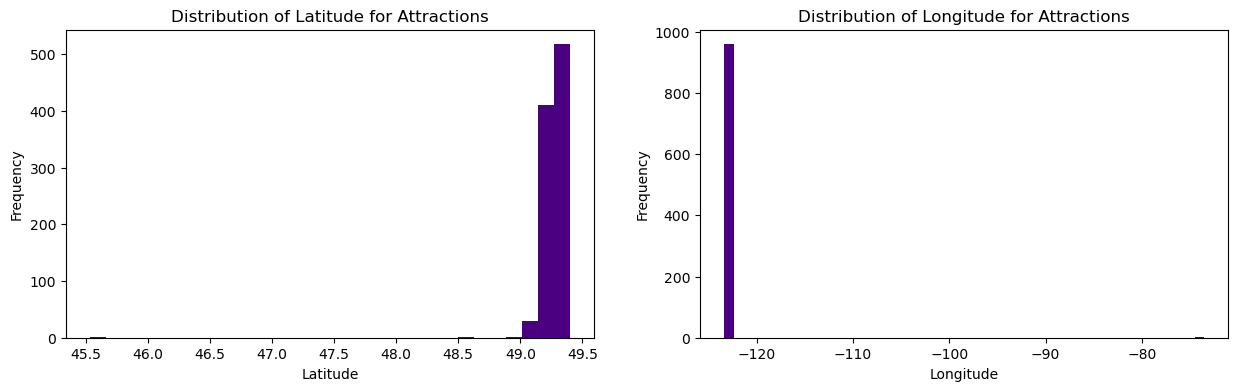

In [3]:
# view original distribuiton of latitude and longitude 
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(address_df['lat'],bins=30,color="indigo")
plt.title('Distribution of Latitude for Attractions')
plt.xlabel('Latitude')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(address_df['lon'],bins=50,color="indigo")
plt.title('Distribution of Longitude for Attractions')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.show()

In [4]:
# remove the 3 outliers latitude and longitude of address_df
# 1st round locating and removing outlier 
index_outlier_1 = address_df[['lat']].idxmin()[0]
print(f"Index of 1st outlier location: {index_outlier_1} \n")
address_df = address_df.drop(index_outlier_1, axis='index')

# 2nd round locating and removing outlier
index_outlier_2 = address_df[['lat']].idxmin()[0]
print(f"Index of 2nd outlier location: {index_outlier_2} \n")
address_df = address_df.drop(index_outlier_2, axis='index')

# 3rd round locating and removing outlier
index_outlier_3 = address_df[['lat']].idxmin()[0]
print(f"Index of 3rd outlier location: {index_outlier_3} \n")
address_df = address_df.drop(index_outlier_3, axis='index')

Index of 1st outlier location: 533 

Index of 2nd outlier location: 634 

Index of 3rd outlier location: 652 



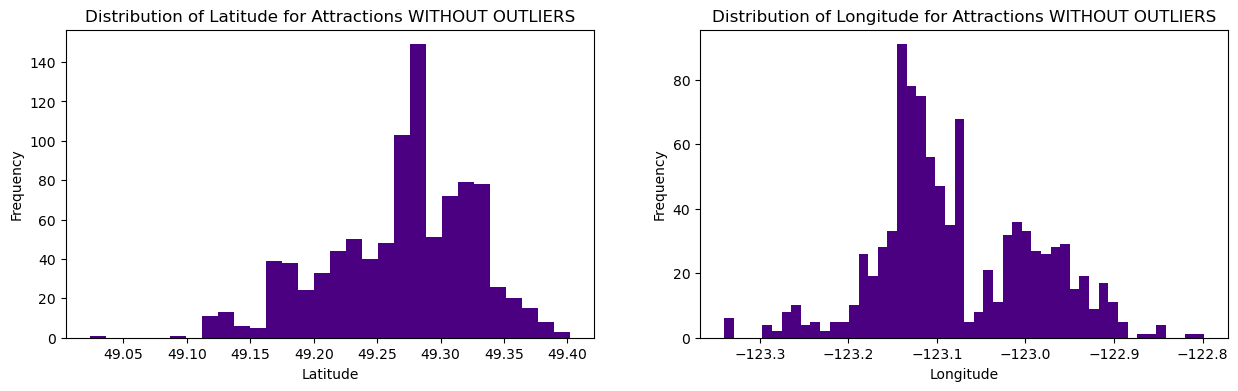

In [5]:
# view original distribuiton of latitude and longitude WITHOUT OUTLIERS
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(address_df['lat'],bins=30,color="indigo")
plt.title('Distribution of Latitude for Attractions WITHOUT OUTLIERS')
plt.xlabel('Latitude')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(address_df['lon'],bins=50,color="indigo")
plt.title('Distribution of Longitude for Attractions WITHOUT OUTLIERS')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.show()

Even with removing some outliers, the latitude data is displaying left-skewed distribution and requires a log tranformation. The longitude data resembles less like a normal distribution and more like a bimodal distribution. The current values of longitude data are all negative and cannot be transformed by log due to its negative values. For now, the original longitude column will be used for the upcoming baseline model. For the next Sprint, other transformations should be explored for Longitude data.

In [6]:
# log the lat column in address_df
log_lat_df = np.log(address_df['lat'])
# display transformed log_df 
log_lat_df.head()

0    3.896184
1    3.895854
2    3.895882
3    3.896017
4    3.896777
Name: lat, dtype: float64

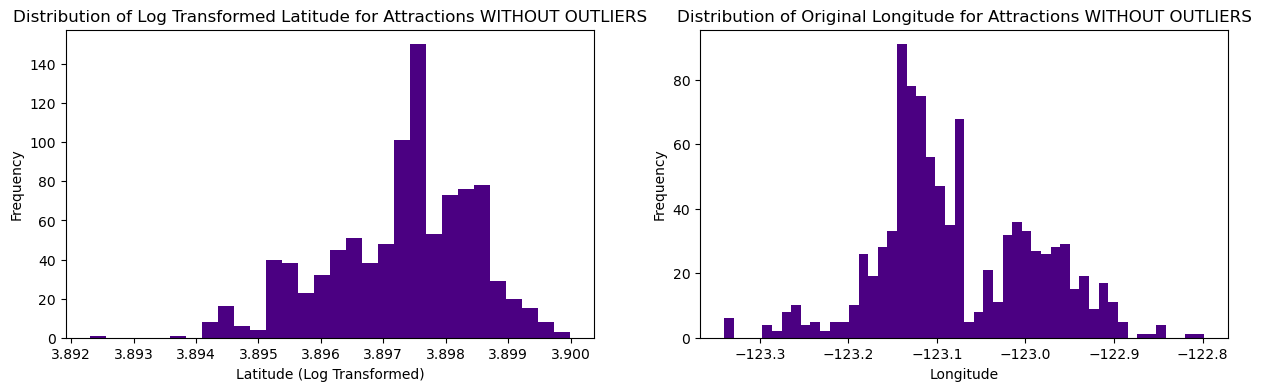

In [7]:
# view distribuiton of log transformed latitude WITHOUT OUTLIERS
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(log_lat_df,bins=30,color="indigo")
plt.title('Distribution of Log Transformed Latitude for Attractions WITHOUT OUTLIERS')
plt.xlabel('Latitude (Log Transformed)')
plt.ylabel('Frequency')
# view original distribuiton of longitude WITHOUT OUTLIERS
plt.subplot(1,2,2)
plt.hist(address_df['lon'],bins=50,color="indigo")
plt.title('Distribution of Original Longitude for Attractions WITHOUT OUTLIERS')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.show()

From the log transformation, the distribution for latitude didn't improve. For the upcoming baseline model, the latitude data prior to the log transformation will be used.

### Text Analysis on Review Keywords
The `review_keywords` column will be modified to become an additional feature in the upcoming clustering model. The values in the `review_keywords` column will fit to a count vectorizer model. The string splitting step is not required given that the column already contain lists of strings.

In [8]:
# load new vancouver attractions data
df = pd. read_csv('new_van_attractions.csv')

# remove outlier index in the same location as address_df for consistency and later modelling
df = df.drop([index_outlier_1,index_outlier_2,index_outlier_3], axis='index')

# change df index to place_id
df.set_index('place_id',inplace=True)

# view information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958 entries, ChIJoQQNT9B3hlQRwbziEuOD0zw to ChIJ4eZqHpBzhlQRbF5hkWtQPN8
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             958 non-null    object 
 1   description      476 non-null    object 
 2   reviews          958 non-null    int64  
 3   website          679 non-null    object 
 4   categories       951 non-null    object 
 5   rating           958 non-null    float64
 6   address          958 non-null    object 
 7   review_keywords  847 non-null    object 
 8   MC_park          958 non-null    bool   
 9   MC_restaurant    958 non-null    bool   
 10  MC_shopping      958 non-null    bool   
 11  MC_tourist       958 non-null    bool   
dtypes: bool(4), float64(1), int64(1), object(6)
memory usage: 71.1+ KB


In [9]:
# view first 10 values in review_keywords columns
df['review_keywords'].head(10)

place_id
ChIJoQQNT9B3hlQRwbziEuOD0zw    fresh, meat, parking, deli, local, cashiers, b...
ChIJcRtGbQ12hlQRhbiiQ5c-KSA    prices, quality, deals, mall, clean, parking, ...
ChIJRYS9gwJ3hlQRhD73njNeHfY    parking, groceries, strip mall, choices, coffe...
ChIJgzxRoT12hlQRdhSdCsG_S-Q    flowers, eggs, spring, local produce, fall, gr...
ChIJzwhBgwh3hlQRtUuytlsraag    vendors, local, music, parking, baked goods, s...
ChIJaYzamVZ3hlQR3jJgDsB8Ip8    prices, groceries, quality, bread, selection, ...
ChIJZX60uzB4hlQROscvUCodE7s    prices, quality, grocery store, asian, snacks,...
ChIJ94RdN8l3hlQRw_2LeEcGRKA    produce, prices, flowers, quality, fresh, milk...
ChIJuSOEa913hlQR4uQMLMU9_TE    selection, clean, mall, table, lunch, vendor, ...
ChIJI-_wr092hlQRztPmBZkn46g    kimbap, produce, sell, hot pot, cashier, quali...
Name: review_keywords, dtype: object

In [10]:
# clean data
forbidden_char = string.punctuation + "1234567890"

def custom_tokenizer(text):
    """
    Custom tokenizer function.

    Outputs: list of tokens, list of tokens (list of strings), the clean and processing document
    """
    # lower text
    text = text.lower()

    # remove special characters
    text = re.sub(f"[{forbidden_char}]", "", text)

    # split into words as tokens
    tokens = text.split()

    # filter stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]

    return tokens

In [11]:
# replace null values in review_keywords column as an empty string
df['review_keywords'] = df['review_keywords'].fillna("")

# checkpoint that nan values are gone in review_keywords column
print(f"Count of Nan values in review_keywords column: {df['review_keywords'].isna().sum()} \n")

# Initialize the CountVectorizer
vector = CountVectorizer(tokenizer=custom_tokenizer)

# Fit the CountVectorizer and transform the data
X = vector.fit_transform(df['review_keywords'])

# Convert the transformed data into a DataFrame for readability
vectorized_df = pd.DataFrame(X.toarray(), columns=vector.get_feature_names_out(),index=df.index)

# view the vectorized data
print(vectorized_df)

Count of Nan values in review_keywords column: 0 

                             aarti  abalone  abba  aberdeen  abgoosht  acai  \
place_id                                                                      
ChIJoQQNT9B3hlQRwbziEuOD0zw      0        0     0         0         0     0   
ChIJcRtGbQ12hlQRhbiiQ5c-KSA      0        0     0         0         0     0   
ChIJRYS9gwJ3hlQRhD73njNeHfY      0        0     0         0         0     0   
ChIJgzxRoT12hlQRdhSdCsG_S-Q      0        0     0         0         0     0   
ChIJzwhBgwh3hlQRtUuytlsraag      0        0     0         0         0     0   
...                            ...      ...   ...       ...       ...   ...   
ChIJmfKAD_R0hlQR2etVxiSVvu8      0        0     0         0         0     0   
ChIJEWq_7hhxhlQR_k-jUi4iX1I      0        0     0         0         0     0   
ChIJuQ8dDy1vhlQRm4YJmRhKXeg      0        0     0         0         0     0   
ChIJYZRldiFyhlQRKAwf2_XOZcc      0        0     0         0         0     0   
C

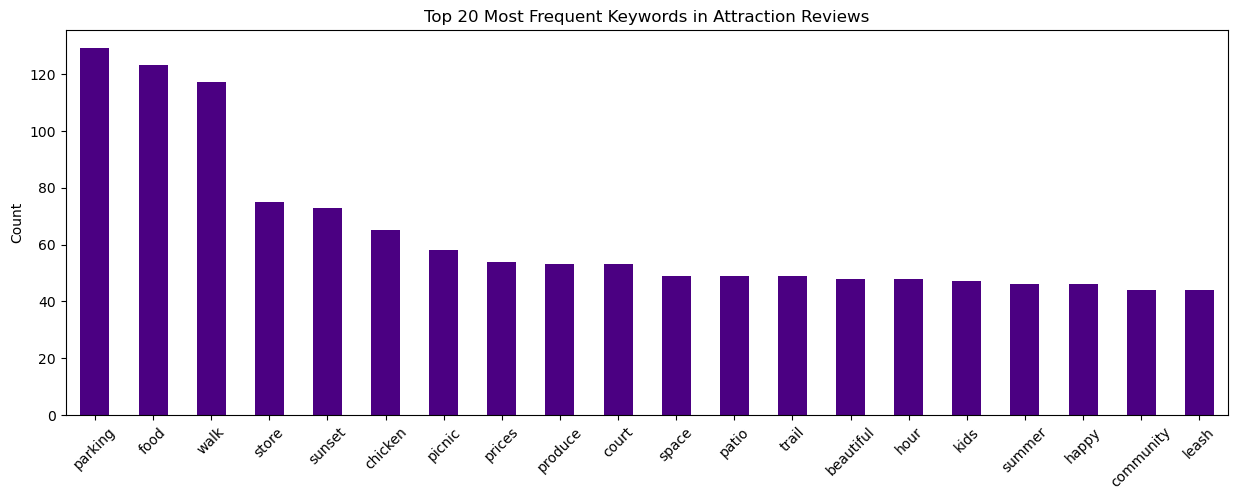

In [12]:
# Word Frequency Analysis on review_keywords
# Convert data to a series to re-attach the tokens as the index
word_counts = pd.Series(X.toarray().sum(axis=0),
                        index=vector.get_feature_names_out())
word_counts = word_counts.sort_values(ascending=False)

# plot Top 20 Most Frequent Keywords
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False,color = 'indigo')
plt.title("Top 20 Most Frequent Keywords in Attraction Reviews")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

**Text Analysis Findings**

Across all attraction types, google map reviewers visiting Vancouver frequently highlight their outdoor experience (ex. sunset, trail, patio, court) and accessibility (ex. walk, parking, hour). Google map reviewers take in consideration the attraction's price and community. For the next Sprint, the review keywords can be broken down by attraction type (ie. main category) to determine additional trends. 

### Transform and Scale Reviews and Rating 

From Sprint 1, the distribution of the `rating` and `reviews` columns displayed the skewed nature of the data. With skewed data, the tail region may act as an outlier for the statistical model, affect a model's performance. To correct the skewed columns require using log transformation.

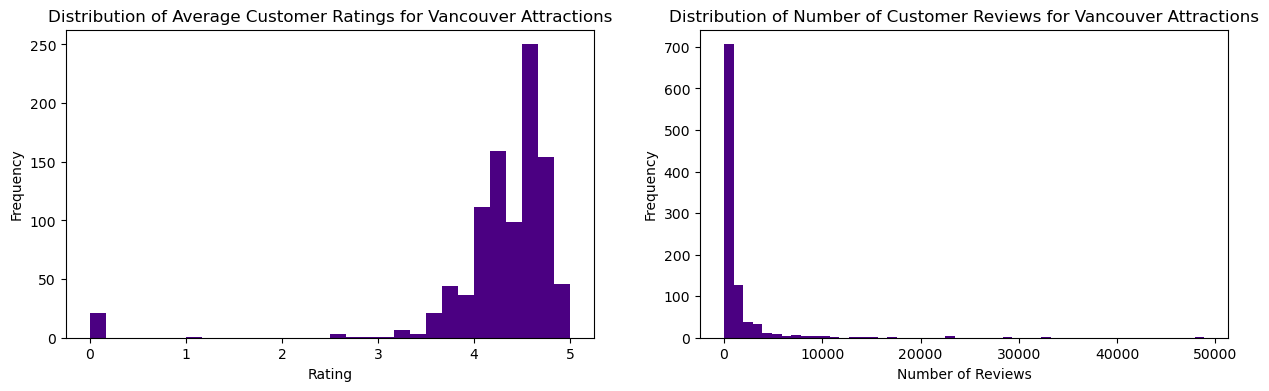

In [13]:
# view skewed distribution of original rating and review columns 
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(df['rating'],bins=30,color="indigo")
plt.title('Distribution of Average Customer Ratings for Vancouver Attractions')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(df['reviews'],bins=50,color="indigo")
plt.title('Distribution of Number of Customer Reviews for Vancouver Attractions')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

In [14]:
# apply a log transformation to rating and review columns in the attractions dataset

# column names in df to transform
skew = ['reviews','rating']
# create new df containing only skewed columns
num_df = df[skew]

# Crate transformer 
preprocessor = ColumnTransformer( transformers =[ ('log_transform', FunctionTransformer(np.log1p), skew)],
                                 remainder = 'passthrough')

#create the pipeline 
pipe = Pipeline([ ('preprocessor', preprocessor),('scaler', StandardScaler())])

transformed_data = pipe.fit_transform(num_df)

scaled_skewed_df = pd.DataFrame(transformed_data, index=num_df.index, columns = num_df.columns)
scaled_skewed_df.head()

,reviews,rating
place_id,,
ChIJoQQNT9B3hlQRwbziEuOD0zw,0.899068,0.251852
ChIJcRtGbQ12hlQRhbiiQ5c-KSA,-0.150151,0.033973
ChIJRYS9gwJ3hlQRhD73njNeHfY,1.076790,0.107965
ChIJgzxRoT12hlQRdhSdCsG_S-Q,-0.162141,0.390599
ChIJzwhBgwh3hlQRtUuytlsraag,0.144956,0.107965


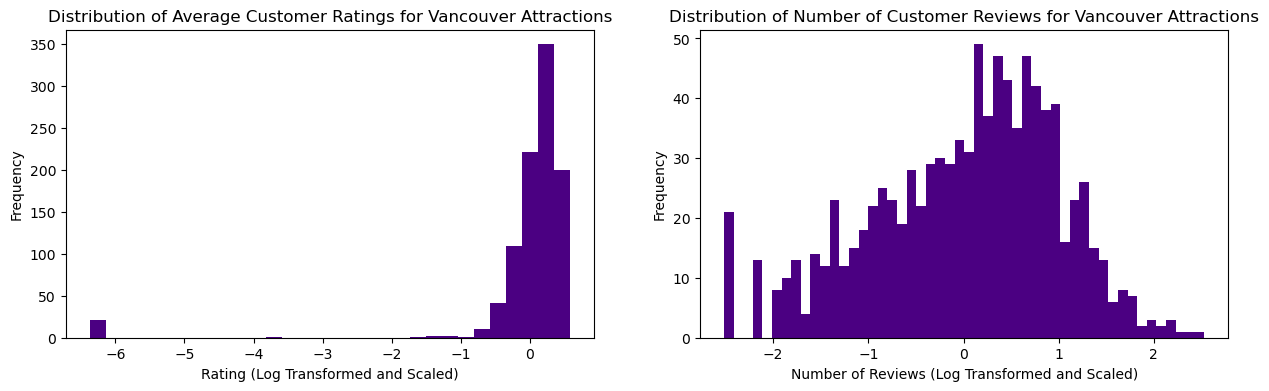

In [15]:
# view distribution of transformed rating and review columns 
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(scaled_skewed_df['rating'],bins=30,color="indigo")
plt.title('Distribution of Average Customer Ratings for Vancouver Attractions')
plt.xlabel('Rating (Log Transformed and Scaled)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(scaled_skewed_df['reviews'],bins=50,color="indigo")
plt.title('Distribution of Number of Customer Reviews for Vancouver Attractions')
plt.xlabel('Number of Reviews (Log Transformed and Scaled)')
plt.ylabel('Frequency')
plt.show()

The log transformation and scaling improved the distribution for Number of Customer Reviews and will be used for the cluster model. Since log transformation and scaling did not improve the distribution for Customer Ratings, it will not be used for the cluster model. The original `rating` and scaled `reviews` columns will be used for the cluster model. 

### PCA Transformation for Final Model Data 

The following dataframes will be created to test pca tranformation. 
1. **model_df**: Consist multiple dataframes of columns of encoded `main_category`, vectorized `review_keywords`, unscaled `lat`, unscaled `lon`, unscaled `reviews` and unscaled `rating`. 
2. **scaled_df**: Consist multiple dataframes of columns of encoded `main_category`, vectorized `review_keywords`, scaled `lat`, scaled `lon`, scaled `reviews` and unscaled `rating`. 
3. **pca_model_df**: pca transformed original_df with reduce dimensionality to 3
4. **pca_scaled_df**: pca transformed scaled_df with reduce dimensionality to 3

The performance of  pca_model_df and pca_scaled_df will be compared to determine which is better used for the upcoming model.

In [16]:
# 1. create model_df

# Add a prefix to all columns in vectorized_df for readability
prefix_vectorized_df = vectorized_df.add_prefix('RK_')

# set index in address_df to match with df
address_df.set_index(df.index,inplace = True)

# create model_df to include the following:
#  - original latitude and longitude from address_df
#  - vectorized review_keywords
#  - original 'rating','MC_park','MC_restaurant','MC_shopping','MC_tourist', 'reviews'
model_df = pd.concat([prefix_vectorized_df, 
                      address_df[['lat','lon']],
                      df[['rating','MC_park','MC_restaurant','MC_shopping','MC_tourist','reviews']]], axis=1)

# treat all nan values as zero for upcoming pca transformation
model_df.fillna(model_df.mean(),inplace=True)

# checkpoint 
model_df.head()


,RK_aarti,RK_abalone,RK_abba,RK_aberdeen,RK_abgoosht,RK_acai,RK_accessible,RK_actor,RK_actors,RK_addicts,...,RK_zombie,RK_zoo,lat,lon,rating,MC_park,MC_restaurant,MC_shopping,MC_tourist,reviews
place_id,,,,,,,,,,,,,,,,,,,,,
ChIJoQQNT9B3hlQRwbziEuOD0zw,0,0,0,0,0,0,0,0,0,0,...,0,0,49.214312,-122.940006,4.5,False,False,False,False,1489
ChIJcRtGbQ12hlQRhbiiQ5c-KSA,0,0,0,0,0,0,0,0,0,0,...,0,0,49.198066,-122.978829,4.2,False,False,False,False,157
ChIJRYS9gwJ3hlQRhD73njNeHfY,0,0,0,0,0,0,0,0,0,0,...,0,0,49.199441,-122.979538,4.3,False,False,True,False,2178
ChIJgzxRoT12hlQRdhSdCsG_S-Q,0,0,0,0,0,0,0,0,0,0,...,0,0,49.206079,-122.982034,4.7,False,False,False,False,153
ChIJzwhBgwh3hlQRtUuytlsraag,0,0,0,0,0,0,0,0,0,0,...,0,0,49.243496,-122.973016,4.3,False,False,False,False,296


In [17]:
# 2. create scaled_df
# instatiate StandardScaler 
ss = StandardScaler()
#fit and transform the lat and lon in model_df using scaler
transformed_lat_lon_df = ss.fit_transform(model_df[['lat','lon']])
#create a new dataframe of our transformed data
df_scaled_lat_lon = pd.DataFrame(transformed_lat_lon_df, index=model_df.index, columns = ['scaled_lat','scaled_lon'])
# view transformed lat and lon
print('df_scaled_lat_lon')
print(df_scaled_lat_lon.head())
print('')

# create model_df to include the following:
#  - original latitude and longitude from address_df
#  - vectorized review_keywords
#  - original 'rating','MC_park','MC_restaurant','MC_shopping','MC_tourist', 'reviews'
scaled_df = pd.concat([prefix_vectorized_df, 
                      df[['rating','MC_park','MC_restaurant','MC_shopping','MC_tourist']],
                      df_scaled_lat_lon,
                      scaled_skewed_df['reviews']], axis=1)

# treat all nan values as zero for upcoming pca transformation
scaled_df. fillna(model_df.mean(),inplace=True)

# checkpoint 
print('scaled_df')
scaled_df.head()

df_scaled_lat_lon
                             scaled_lat  scaled_lon
place_id                                           
ChIJoQQNT9B3hlQRwbziEuOD0zw   -0.941876    1.560134
ChIJcRtGbQ12hlQRhbiiQ5c-KSA   -1.222117    1.123878
ChIJRYS9gwJ3hlQRhD73njNeHfY   -1.198406    1.115906
ChIJgzxRoT12hlQRdhSdCsG_S-Q   -1.083896    1.087859
ChIJzwhBgwh3hlQRtUuytlsraag   -0.438481    1.189197

scaled_df


,RK_aarti,RK_abalone,RK_abba,RK_aberdeen,RK_abgoosht,RK_acai,RK_accessible,RK_actor,RK_actors,RK_addicts,...,RK_zombie,RK_zoo,rating,MC_park,MC_restaurant,MC_shopping,MC_tourist,scaled_lat,scaled_lon,reviews
place_id,,,,,,,,,,,,,,,,,,,,,
ChIJoQQNT9B3hlQRwbziEuOD0zw,0,0,0,0,0,0,0,0,0,0,...,0,0,4.5,False,False,False,False,-0.941876,1.560134,0.899068
ChIJcRtGbQ12hlQRhbiiQ5c-KSA,0,0,0,0,0,0,0,0,0,0,...,0,0,4.2,False,False,False,False,-1.222117,1.123878,-0.150151
ChIJRYS9gwJ3hlQRhD73njNeHfY,0,0,0,0,0,0,0,0,0,0,...,0,0,4.3,False,False,True,False,-1.198406,1.115906,1.076790
ChIJgzxRoT12hlQRdhSdCsG_S-Q,0,0,0,0,0,0,0,0,0,0,...,0,0,4.7,False,False,False,False,-1.083896,1.087859,-0.162141
ChIJzwhBgwh3hlQRtUuytlsraag,0,0,0,0,0,0,0,0,0,0,...,0,0,4.3,False,False,False,False,-0.438481,1.189197,0.144956


In [18]:
# 3. create pca_model_df
# instantiate the pca transformation 
pca_model = PCA(n_components = 3)

#fit and transform the model_df using PCA 
pca_transform_model = pca_model.fit_transform(model_df)

# create a dataframe with PCA
pca_model_df = pd.DataFrame(pca_transform_model, columns = ['PC0', 'PC1', 'PC2'], index = model_df.index)

# view the pca transformed model dataframe 
pca_model_df.head()

,PC0,PC1,PC2
place_id,,,
ChIJoQQNT9B3hlQRwbziEuOD0zw,345.420665,-0.083435,0.516719
ChIJcRtGbQ12hlQRhbiiQ5c-KSA,-986.579336,0.224562,0.540013
ChIJRYS9gwJ3hlQRhD73njNeHfY,1034.420693,0.506822,1.741830
ChIJgzxRoT12hlQRdhSdCsG_S-Q,-990.579336,-0.370598,0.399568
ChIJzwhBgwh3hlQRtUuytlsraag,-847.579335,0.190930,0.970336


In [19]:
# plot the pca transformed data of model_df 
# Why? compare against upcoming pca transformed data of scaled_df and to determine when to perform PCA 
plt.figure(figsize=(12,15))
fig = px.scatter_3d(pca_model_df, x='PC0', y='PC1', z='PC2', opacity=0.05)
fig.show()

<Figure size 1200x1500 with 0 Axes>

In [20]:
# 4. create pca_scaled_df
# instantiate the pca transformation 
pca_scale = PCA(n_components = 3)

#fit and transform the scaled_df using PCA 
pca_transform_scale = pca_scale.fit_transform(scaled_df)

# create a dataframe with PCA
pca_scaled_df = pd.DataFrame(pca_transform_scale, columns = ['PC0', 'PC1', 'PC2'], index = model_df.index)

# view the pca transformed scale dataframe 
pca_scaled_df.head()

,PC0,PC1,PC2
place_id,,,
ChIJoQQNT9B3hlQRwbziEuOD0zw,1.916924,-0.324992,-0.652836
ChIJcRtGbQ12hlQRhbiiQ5c-KSA,1.647084,0.521623,0.147369
ChIJRYS9gwJ3hlQRhD73njNeHfY,2.095032,-0.747920,-0.045530
ChIJgzxRoT12hlQRdhSdCsG_S-Q,1.449498,0.354950,-0.088519
ChIJzwhBgwh3hlQRtUuytlsraag,1.225382,0.198185,-0.419851


In [21]:
# plot the pca transformed data of scaled_df 
# Why? compare against previous pca transformed data of model_df and to determine when to perform PCA 
plt.figure(figsize=(12,15))
fig = px.scatter_3d(pca_scaled_df, x='PC0', y='PC1', z='PC2', opacity=0.05)
fig.show()

<Figure size 1200x1500 with 0 Axes>

From the 3d graphs, the PCA should be performed before generating the cluster model on the scaled data.

For the upcoming baseline model, the scaled_df will be used. 

--- 

## Modelling
With the data ready for modelling, a clustering model will be made with optimization and evaluation.

The following models will be used to cluster the data: 
- K-Means 
- Gaussian Mixture Model
- Hierarchical Clustering (Agglomerative)

The silhoulette_score will be used to evaluate the model performance. 

ks: [2 3 4 5 6 7 8 9]
Currently working on k = 2 

Currently working on k = 3 

Currently working on k = 4 

Currently working on k = 5 

Currently working on k = 6 

Currently working on k = 7 

Currently working on k = 8 

Currently working on k = 9 



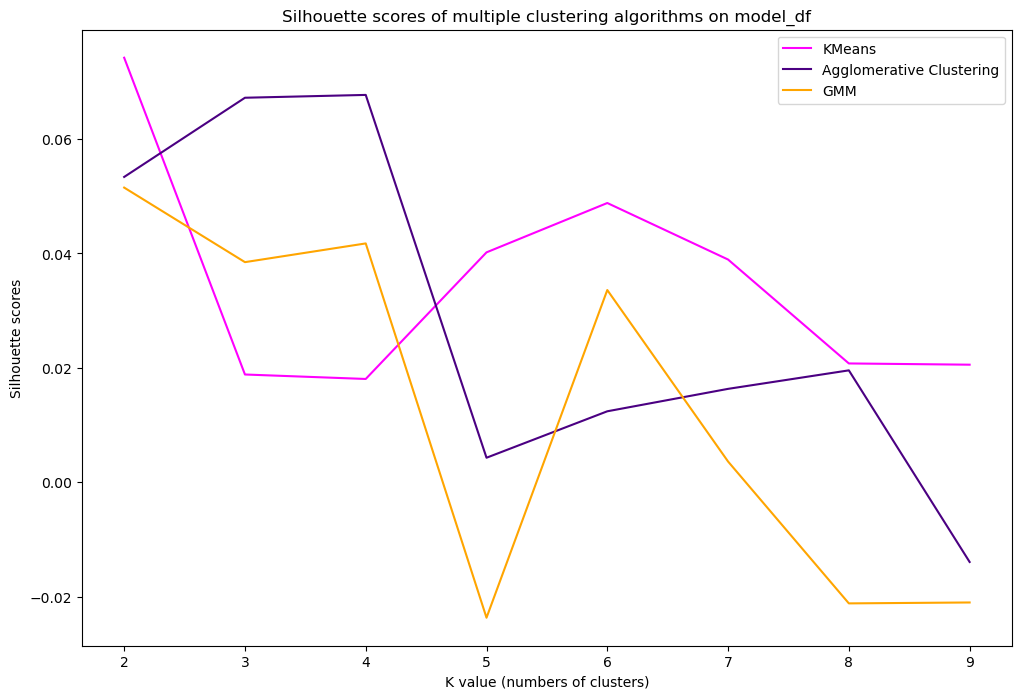

In [22]:
# empty list of silhoulette_score for all 3 models mentioned above
silScoresKMeans = []
silScoresGauss = []
silScoresAgglom = []

# array of number of clusters to iterate over all 3 models
ks = np.arange(2, 10)
print(f"ks: {ks}")

#Loop through the values of K (numbers of clusters), fit one of each type of model, and assess the silhouette score at each value of K
for k in ks:
    print(f'Currently working on k = {k} \n')

    #instantiate these three models
    kmeans = KMeans(n_clusters = k)
    gauss = GaussianMixture(n_components = k)
    agglom = AgglomerativeClustering(n_clusters = k, linkage = 'ward')

    #fit the three models to the data
    kmeans.fit(scaled_df)
    gauss.fit(scaled_df)
    agglom.fit(scaled_df)

    #populate the lists with the silhouette scores!
    silScoresKMeans.append(silhouette_score(scaled_df, kmeans.labels_))
    silScoresAgglom.append(silhouette_score(scaled_df, agglom.labels_))
    silScoresGauss.append(silhouette_score(scaled_df, gauss.predict(scaled_df)))

# plot the silhouette scores of each model 
plt.figure(figsize=(12,8))
plt.plot(ks, silScoresKMeans, label='KMeans', color='magenta')
plt.plot(ks, silScoresAgglom, label='Agglomerative Clustering', color='indigo')
plt.plot(ks, silScoresGauss, label='GMM', color='orange')
plt.legend() 
plt.title('Silhouette scores of multiple clustering algorithms on model_df')
plt.ylabel('Silhouette scores')
plt.xlabel('K value (numbers of clusters)')
plt.show()

The process will be repeated with the pca transformed model dataframe to determine whether the clustering models are producing higher or lower silouette_score. 

Currently working on k = 2
Currently working on k = 3
Currently working on k = 4
Currently working on k = 5
Currently working on k = 6
Currently working on k = 7
Currently working on k = 8
Currently working on k = 9


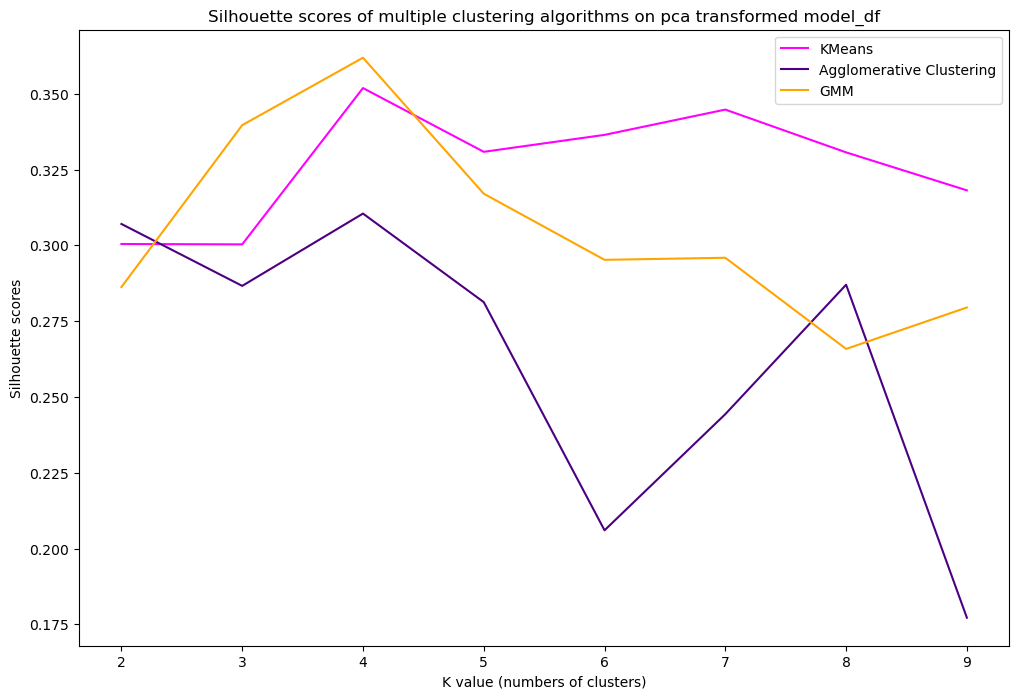

In [23]:
# empty list of silhoulette_score for all 3 models with pca transformation
pca_silScoresKMeans = []
pca_silScoresGauss = []
pca_silScoresAgglom = []

#Loop through the values of K (numbers of clusters), fit one of each type of model, and assess the silhouette score at each value of K
for k in ks:
    print(f'Currently working on k = {k}')

    #instantiate these three models
    kmeans = KMeans(n_clusters = k)
    gauss = GaussianMixture(n_components = k)
    agglom = AgglomerativeClustering(n_clusters = k, linkage = 'ward')

    #fit the three models to the data
    kmeans.fit(pca_scaled_df)
    gauss.fit(pca_scaled_df)
    agglom.fit(pca_scaled_df)

    #populate the lists with the silhouette scores
    pca_silScoresKMeans.append(silhouette_score(pca_scaled_df, kmeans.labels_))
    pca_silScoresGauss.append(silhouette_score(pca_scaled_df, agglom.labels_))
    pca_silScoresAgglom.append(silhouette_score(pca_scaled_df, gauss.predict(pca_scaled_df)))

# plot the silhouette scores of each model 
plt.figure(figsize=(12,8))
plt.plot(ks, pca_silScoresKMeans, label='KMeans', color='magenta')
plt.plot(ks, pca_silScoresAgglom, label='Agglomerative Clustering', color='indigo')
plt.plot(ks, pca_silScoresGauss, label='GMM', color='orange')
plt.legend() 
plt.title('Silhouette scores of multiple clustering algorithms on pca transformed model_df')
plt.ylabel('Silhouette scores')
plt.xlabel('K value (numbers of clusters)')
plt.show()

**Modelling Findings**

- Clustering before to PCA transformation results in best performing model based on silhoulette score is **KMeans(n_components = 2)** with **~0.075**.
- Clustering after to PCA transformation results in best performing model based on silhoulette score is **GaussianMixture(n_components = 4)** with **~0.365**.
 
  Baseline models before and after PCA transformation produce weak silhoulette scores from the nature of dimensionality. Given the large dimensionality of the data, it becomes difficult to achieve high values because of the curse of dimensionality, as the distances become more similar.
 
---

## Next Steps for Sprint 3
- Feature Engineering
  - `review_keywords` transformed with TF-IDF and/or Word2Vec
  - `rating` transformed with different scales (ie. MaxAbsScaler, MinMaxScaler, Normalizer) 
  - research transformations relating to the bimodal distribution of data for `lon`
- Parameter tuning for GaussianMixture Model
- Research and create sample users to act as user input in recommendation system and review model's performace
- Use content-based filtering to recommend items with the highest feature similarity to the user's profile 